# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Fitting-to-the-Mauna-Loa-CO_2-record" data-toc-modified-id="Fitting-to-the-Mauna-Loa-CO_2-record-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Fitting to the Mauna Loa $CO_2$ record</a></div><div class="lev2 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev2 toc-item"><a href="#Obtaining-the-data" data-toc-modified-id="Obtaining-the-data-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Obtaining the data</a></div><div class="lev3 toc-item"><a href="#Downloading-the-data" data-toc-modified-id="Downloading-the-data-121"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Downloading the data</a></div><div class="lev3 toc-item"><a href="#Exploring-the-data" data-toc-modified-id="Exploring-the-data-122"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Exploring the data</a></div><div class="lev2 toc-item"><a href="#Loading-the-data-into-Python" data-toc-modified-id="Loading-the-data-into-Python-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Loading the data into Python</a></div><div class="lev2 toc-item"><a href="#A-model-for-CO_2-concentration" data-toc-modified-id="A-model-for-CO_2-concentration-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>A model for $CO_2$ concentration</a></div><div class="lev3 toc-item"><a href="#A-linear-trend-model" data-toc-modified-id="A-linear-trend-model-141"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>A linear trend model</a></div><div class="lev3 toc-item"><a href="#A-quadratic-model" data-toc-modified-id="A-quadratic-model-142"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>A quadratic model</a></div><div class="lev2 toc-item"><a href="#Solving-the-problem-using-linear-algebra" data-toc-modified-id="Solving-the-problem-using-linear-algebra-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Solving the problem using linear algebra</a></div><div class="lev3 toc-item"><a href="#Solution-using-np.linalg.lstsq" data-toc-modified-id="Solution-using-np.linalg.lstsq-151"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Solution using <code>np.linalg.lstsq</code></a></div><div class="lev2 toc-item"><a href="#A-model-with-seasonality" data-toc-modified-id="A-model-with-seasonality-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>A model with seasonality</a></div>

# Fitting to the Mauna Loa $CO_2$ record

## Introduction

$CO_2$ concentration in the atmosphere has been steadily increasing. The flask measurements collected in Mauna Loa provide a fairly long time series that allows us to see the temporal evolution of this trace gas. 


<div class="alert alert-success">
<b>Why</b> is CO2 important?
</div>

The time series looks like this

![Mauna Loa CO2 record](https://www.pmel.noaa.gov/co2/files/co2_data_mlo_med.jpg)

<div class="alert alert-success">
Knowing that Mauna Loa is in Hawaii (Northern Hemisphere), can you broadly explain what's going on?
</div>

In today's session, we shall consider how to "model" the $CO_2$ record. We'll develop some simple models of $CO_2$ as a function of time, and will try to "fit" them to the data.

<div class="alert alert-success">
Can you think why fitting some models based on time to the Mauna Loa record might not be particularly insightful?
</div>

We first have an import cell that deals with importing all the usual modules that we'll require: numpy, matplotlib as well as pandas to read the data file. If you put all your imports at the top and run them first, they should be available for all other cells...

In [2]:
from pathlib import Path  # Checks for files and so on
import numpy as np  # Numpy for arrays and so on
import pandas as pd
import sys
import matplotlib.pyplot as plt  # Matplotlib for plotting
# Ensure the plots are shown in the notebook
%matplotlib inline

# Instead of using requests, we might as well use Python's buil-in
# HTTP downloader
from urllib.request import urlretrieve

## Obtaining the data

### Downloading the data

The data are available on line from [NOAA](https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html). We want the monthly  average dataset, which can be found there. If the data is not yet available in your system, the next Python cell will download it from [`ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt`](ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt). In this case, because the url is an FTP one we will use the `urllib2` package rather than requests, that doesn't deal with FTP. We will save it to a file with the same name locally:

In [3]:
# The remote URL for the data file is address:
address = 'ftp://aftp.cmdl.noaa.gov/products/trends/co2/'
# We'll create a folder if it doesn't exist in the data folder for
# the data
dest_path = Path("data/Mauna_Loa/").mkdir(parents=True, exist_ok=True)
fname = Path("data/Mauna_Loa/co2_mm_mlo.txt")
if not fname.exists():
    # Data file not present, let's download it
    print("Downloading remote file")
    urlretrieve(f"{address:s}/{fname.name:s}", fname.as_posix())
    print(f"Remote file downloaded to {fname.name:s}")
else:
    print(f"{fname.name:s} already present, no need to download again")

co2_mm_mlo.txt already present, no need to download again


### Exploring the data

We can have a peek at the text file. We note that most of the first few lines are "comments" (lines start by `#`), which describe useful *metadata*. We note that we have several columns of data:

1. The year
2. The month
3. The decimal date
4. The monthly mean CO2 mole fraction determined from daily averages

We will mostly be bothered about columns three and four.


We can peek at the data (first 73 lines) using the UNIX shell [`head`](http://www.linfo.org/head.html) command (this will not work on Windows, but will probably work on OSX):

In [4]:
!head -n 73 co2_mm_mlo.txt

head: cannot open ‘co2_mm_mlo.txt’ for reading: No such file or directory


## Loading the data into Python

This is quite straightforward using [`np.loadtxt`](https://scipython.com/book/chapter-6-numpy/examples/using-numpys-loadtxt-method/)...

We will also "mask" if the data is missing checking for the value -99.99...

/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


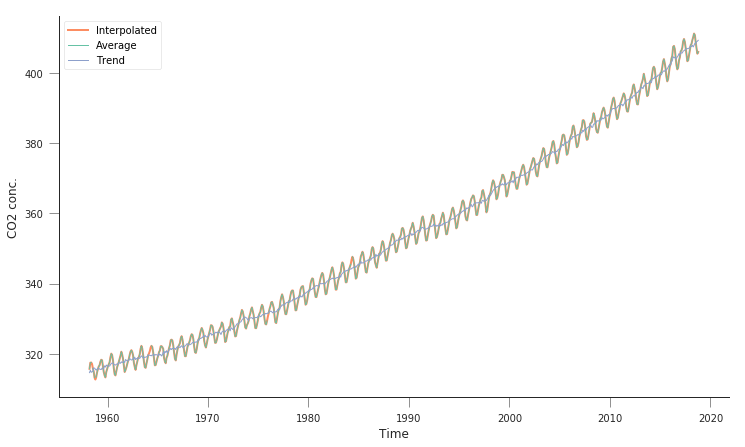

In [5]:
hdr = [
    "year", "month", "decimal_date", "average", "interpolated", "trend", "days"
]
co2 = pd.read_csv(
    fname,
    comment='#',
    delim_whitespace=True,
    names=hdr,
    na_values=[-99.99, -1])

plt.figure(figsize=(12, 7))
plt.plot(co2.decimal_date, co2.interpolated, '-', lw=2, label="Interpolated")
plt.plot(co2.decimal_date, co2.average, '-', lw=1, label="Average")
plt.plot(co2.decimal_date, co2.trend, '-', lw=1, label="Trend")
plt.xlabel("Time")
plt.ylabel("CO2 conc.")
plt.legend(loc="best")

So this is quite similar to what we had above. There's an average line, an interpolated line, as well as some smoothed trend line. We're interested in the interpolated line.

## A model for $CO_2$ concentration

### A linear trend model

We might be curious about a simple model for $CO_2$ concentration. Perhaps the simplest model is a linear trend, which we can write as the concentration at some time step $i$, $W_i$ being just a linear scaling of the time $t_i$:

$$
W_i = m \cdot t_i + c.
$$

We can define a Python function for this very easily:

In [6]:
def linear_model(p, t):
    m, c = p
    return m * t + c

We can now try to plot some model trajectories and the data by supplying parameters for the slope ($m$) and intercept ($c$). Let's start by assuming that the slope can be approximated by the difference between minimum and maximum concentrations divided  by the number of timesteps:

$$
m \approx  \frac{411-310}{728}
$$

$c$ is the minimum value, so $c\approx 310$.

There are 728 steps in the data
Maximum CO2 concentration 411.240000
Minimum CO2 concentration 312.660000
Sum of squared residuals: 14997.256482063598


/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


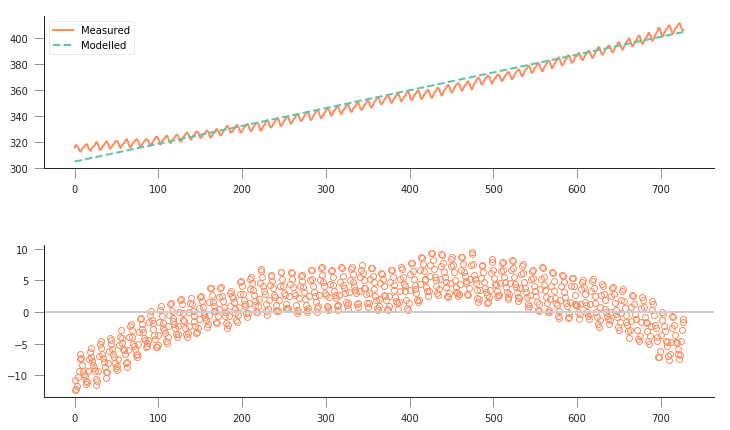

In [7]:
n_times = co2.interpolated.shape[0]
max_co2 = co2.interpolated.max()
min_co2 = co2.interpolated.min()
print(f"There are {n_times:d} steps in the data")
print(f"Maximum CO2 concentration {max_co2:f}")
print(f"Minimum CO2 concentration {min_co2:f}")
x = np.arange(n_times)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 7))
axs[0].plot(x, co2.interpolated, '-', label="Measured")
m = (403. - 305.) / 716
c = 305.
axs[0].plot(x, linear_model([m, c], x), '--', label="Modelled")
axs[0].legend(loc="best")
axs[1].plot(x, linear_model([m, c], x) - co2.interpolated, 'o', mfc="none")
axs[1].axhline(y=0, lw=2, c="0.8")
S = np.sum((linear_model([m, c], x) - co2.interpolated)**2)
print("Sum of squared residuals: {}".format(S))

So, not really a great fit... The overall shape is a bit off, and the model isn't really fitting the annual seasonality in the curve. The residuals plot tells us that the residuals aren't really noise around zero: they show a very clear trend, suggesting that **the model is too simple to fit the data**.  

### A quadratic model

Maybe we need a higher order model, like a quadratic model:

$$
W_i = a_0 \cdot t_i^2  + a_1 \cdot t_i + a_2.
$$

In this case, it is a bit harder to eyeball what good starting parameters for $\left[a_0, a_1, a_2\right]$ would be. A strategy for this would be to consider what a good fit would look like, and then use this to define a metric of good fit. A good fit would basically overlap the measurements, being indistinguishable from them. The *residual* is the difference between the measurement and the model. In this case, it can be positive or negative (whether the model over- or undershoots the observations), but by squaring the residual we get rid of the sign. Then we can add up all the squared residuals, and the best fit will be the one that has the lowest sum of squares. This is in essence the [method of least squares](https://en.wikipedia.org/wiki/Least_squares). Let's see how this works *intuitevely*: we'll loop over the parameters and plot the different predicted concentrations... First we need our model function...

In [8]:
def quadratic_model(p, t):
    a0, a1, a2 = p
    return a0 * t**2 + a1 * t + a2

We can get a feeling of what the parameters might be just by eyeballing reading up some points from the graph, and then solving the system manually:

$$
\begin{aligned}
403 &= a_0\cdot (728)^2 + a_1\cdot (728) + a_2\\
340 &= a_0\cdot (300)^2 + a_1\cdot (300) + a_2\\
315 &= a_0\cdot (0)^2 + a_1\cdot (0) + a_2\\
\end{aligned}
$$

From this, we can get some rough estimates, which in this case are

$$
\begin{aligned}
a_0 &= 9.5\cdot 10^{-5}\\
a_1 &= 5.48\cdot 10^{-2}\\
a_2 &= 315.\\
\end{aligned}
$$

We can just basically run the model around these numbers and plot the different model predictions with a loop over $a_0$ and another one over $a_1$ (assuming $a_2$ is well defined)

/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


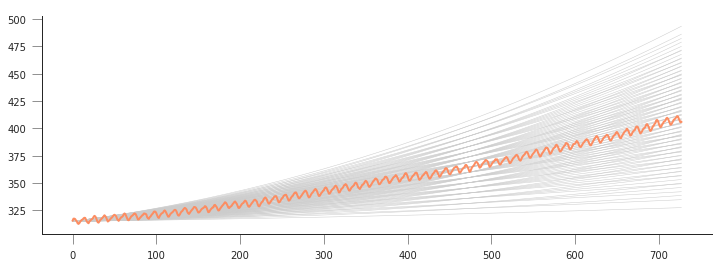

In [9]:
plt.figure(figsize=(12, 4))

a2 = 315.
for a0 in np.linspace(1e-5, 20e-5, 10):
    for a1 in np.linspace(1e-2, 10e-2, 10):
        plt.plot(x, quadratic_model([a0, a1, a2], x), '-', lw=0.5, c="0.8")

plt.plot(x, co2.interpolated, '-', label="Measured")

This is quite complicated, we can see that there might be a good line of fit, but we don't see clearly what parameters provide it! We can store the goodness of fit metric (sum of squared residuals) in a 2D array and then plot it as an image. It should be more obvious where the minimum lies...

/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


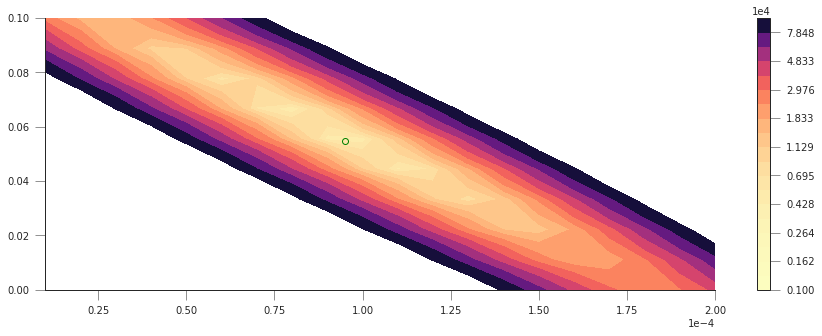

In [10]:
# Define a 2D array for the sum of squares (sos)
sos = np.zeros((10, 20))
# the time axis redefined again, in case it got confused with something else
x = np.arange(n_times)

# first loop is over a0, 20 steps between 1e-5 and 20e-5
for ii, a0 in enumerate(np.linspace(1e-5, 20e-5, 20)):
    # 2nd loop is over a1, 10 steps between 1e-2 and 10e-2
    for jj, a1 in enumerate(np.linspace(1e-2, 10e-2, 10)):
        # for the current values of a0 and a1, calculate the residual
        residual = quadratic_model([a0, a1, a2], x) - co2.interpolated
        sq_residual = residual * residual
        sum_of_residuals = sq_residual.sum()
        # Store the sum_of_residuals into our array
        sos[jj, ii] = np.sum(
            (quadratic_model([a0, a1, a2], x) - co2.interpolated)**2)

# Plotting!
plt.figure(figsize=(15, 5))
# Set up the x and y axis for the plot
yy = np.linspace(1e-5, 20e-5, 20)
xx = np.linspace(1e-5, 10e-2, 10)
# Do a contour plot. The logspace bit basically defines the location
# of 20 contour lines
c = plt.contourf(yy, xx, sos, np.logspace(3, 5, 20), cmap=plt.cm.magma_r)
# Colorbar
plt.colorbar()
# Now, just plot the rough guess of a0 and a1 into this plot
# We want to plot an empty circle with a green edge
plt.plot(9.51242659e-05, 5.47960536e-02, 'o', mfc="None", mec="g")

So that's pretty interesting, we get a very clear "valley", with a minimum pretty close to where our first rough guess is... The shape is quite interesting: if we start at the first guess point, and move along the $x-$ or $y-$ axes, we quickly go into areas of large error. However, if we move along the diagonal line, we will be in the "trough" of the cost function, provided that when you move "up" (positive $a_0$), you also move "left" (negative $a_1$), or if you move "down" (negative $a_0$), you also move "right" (positive $a_1$). Basically, the cost function does not change if you can get the two parameters to co-operate and compensate the effect of each other.


Let's find out where the actual minimum from our brute-force approach is. We can do this quickly by creating a mask where all the elements are `False` except where the minimum value of `sos` is located. We can then use this mask to multiply our `x` and `y` axes and just select the unique values that are larger than 0.

In [11]:
print(f"Best SoS: {sos.min():g}")
sos_mask = sos == sos.min()
u1 = np.unique(yy[None, :] * sos_mask)
yy_opt = u1[u1 > 0]
u2 = np.unique(xx[:, None] * sos_mask)
xx_opt = u2[u2 > 0]

Best SoS: 4182.24


The Sum of Squares of the first example was  around 15000, so we've improved our modelling by adding an extra (quadratic term). This is usually the case: you can improve your goodness of fit by adding extra terms, but usually at the cost of *specialising* your model too much to the training data. This will usually result in poor predictive abilities for the model outside the training region. Which isn't cool.


We can plot now the cost function, as well as our first rough guess and the final guess:

/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


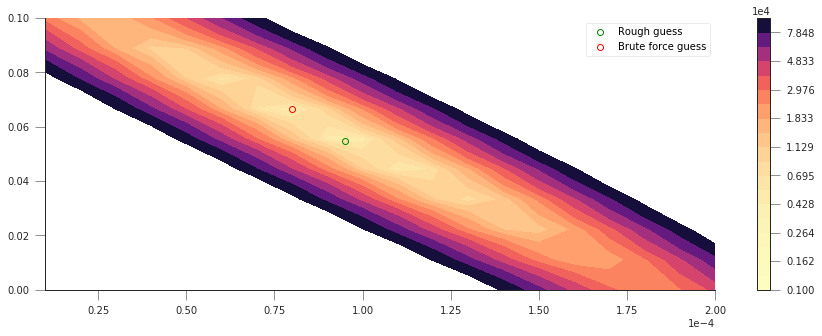

In [12]:
# Plotting!
plt.figure(figsize=(15, 5))
# Set up the x and y axis for the plot
yy = np.linspace(1e-5, 20e-5, 20)
xx = np.linspace(1e-5, 10e-2, 10)
# Do a contour plot. The logspace bit basically defines the location
# of 20 contour lines
c = plt.contourf(yy, xx, sos, np.logspace(3, 5, 20), cmap=plt.cm.magma_r)
# Colorbar
plt.colorbar()
# Now, just plot the rough guess of a0 and a1 into this plot
# We want to plot an empty circle with a green edge
plt.plot(
    9.51242659e-05,
    5.47960536e-02,
    'o',
    mfc="None",
    mec="g",
    label="Rough guess")
plt.plot(yy_opt, xx_opt, 'o', mfc="None", mec="r", label="Brute force guess")
plt.legend(loc="best")

That's not *too bad*! But althogh we found a minimum, we haven't shown how well our model really fits the observations! Let's plot the prediction (with the "optimised parameters" as well as the roughly guessed ones):

/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


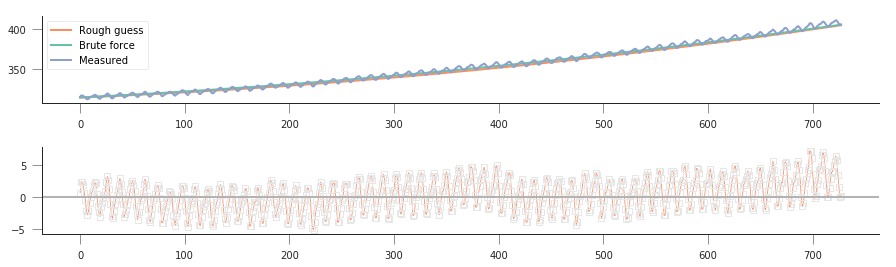

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 4))

a2 = 315.
axs[0].plot(
    x,
    quadratic_model([9.51242659e-05, 5.47960536e-02, a2], x),
    '-',
    label="Rough guess")
axs[0].plot(
    x, quadratic_model([yy_opt, xx_opt, a2], x), '-', label="Brute force")

axs[0].plot(x, co2.interpolated, '-', label="Measured")
axs[0].legend(loc="best")

axs[1].plot(
    x,
    co2.interpolated - quadratic_model([yy_opt, xx_opt, a2], x),
    's-',
    lw=0.8,
    mfc="none",
    mec="0.9")
axs[1].axhline(0, color="0.7")

So solvng by brute force with a quadratic appears to have worked better than fitting with our linear model. The residuals now mostly lie in the -5 to 5 units range, whereas the linear model had residuals floating around -12 and 12 or thereabouts. It is also clear that we're missing out on the seasonality, and some rates of growth (particularly at the end) seem to be underemphasised.

## Solving the problem using linear algebra 

So we can see that our brute force search has given us a better fit than eyeballing it, which is what one might expect. It should be possible to solve this analytically. Let's write this as a matrix problem:

$$
\begin{aligned}
\mathbf{A}\cdot\vec{x}&=\vec{y}\\
\mathbf{A}&=\begin{bmatrix} 
t_1^2 & t_1 & 1 \\
t_2^2 & t_2 & 1 \\
t_3^2 & t_3 & 1 \\
\vdots & \vdots \vdots \\
t_N^{2} & t_N & 1 \\\end{bmatrix}\\
\vec{x} &=\begin{bmatrix}a_0\\a_1\\a_2 \end{bmatrix}\\
\vec{y} &=\begin{bmatrix}W_1\\W_2\\W_3\\ \vdots \\W_N \end{bmatrix}\\
\end{aligned}
$$


<div class="alert alert-success">
Spend some time satisfying yourself that you understand how the previous matrices and vectors work together.
</div>

So, we see that this is really an overdetermined linear problem, where we've got more observations ($N$) than parameters (3). We can solve this by calculating the pseudo inverse:

$$
\vec{x} = \left[\mathbf{A}^{\top}\mathbf{A}  \right]^{-1}\mathbf{A}^{\top}\vec{y},
$$
where $^{\top}$ is the **transpose**, and $^{-1}$ is the inverse matrix. We can solve this problem easily in Python, which can deal with linear algebra nicely. The [`np.linalg.lstsq`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.lstsq.html) method has a direct solver, or you can also work it out by calculating the inverse matrix yourself. The latter approach is usually numerically more unstable, so we won't be looking into it.

### Solution using `np.linalg.lstsq`

In this case, we need to define the matrix $\mathbf{A}$. The observations vector $\vec{y}$ is already defined. What is needed is to weed out the invalid measurements in both $\mathbf{A}$ and $\vec{y}$. We then use [`np.linalg.lstsq`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.lstsq.html) to solve the linear overdetermined system. This returns a number of things:

1. The solution vector.
2. The sum of squared residuals.
3. The rank of the matrix $\mathbf{A}$.
4. The eigenvalues.

We're really only interested in the first two (the other two outputs are important, but this is not your methods course!).

In [15]:
# We create the A matrix
x = np.arange(n_times)
A = np.array([x**2, x, np.ones_like(x)])
# Now put the observations into y
y = co2.interpolated

# Call lstsq
xopt, sum_of_residuals, r, evals = np.linalg.lstsq(A.T, y)
rough_guess = [9.51242659e-05, 5.47960536e-02, 315]
brute_force = [yy_opt, xx_opt, 315]
print("Parameter   Matrix       Brute force     Rough guess")
for par in range(3):
    print("a{}:         {:08.5e}\t {:08.5e}\t {:08.5e}".format(
        par, xopt[par], float(brute_force[par]), rough_guess[par]))
print("Sum of residuals: {:g}".format(float(sum_of_residuals)))

Parameter   Matrix       Brute force     Rough guess
a0:         8.79184e-05	 8.00000e-05	 9.51243e-05
a1:         6.53383e-02	 6.66700e-02	 5.47961e-02
a2:         3.14462e+02	 3.15000e+02	 3.15000e+02
Sum of residuals: 3563.41


/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


The parameters we got from the linear solver are very similar to the brute force method. If we had used a finer grid in the brute force model, we'd get even closer, but at the price of incresing the number of model evaluations. We can also see that using the analytic least squares solution results in the actual minimum of the cost function, not a value close to it.

In the linear algebra case, the procedure is very simple, and provided the matrix $\mathbf{A}$ is invertible, one is mostly guaranteed a good solution.

As usual, let's us plot model, data and residuals and see what we can spot...

/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


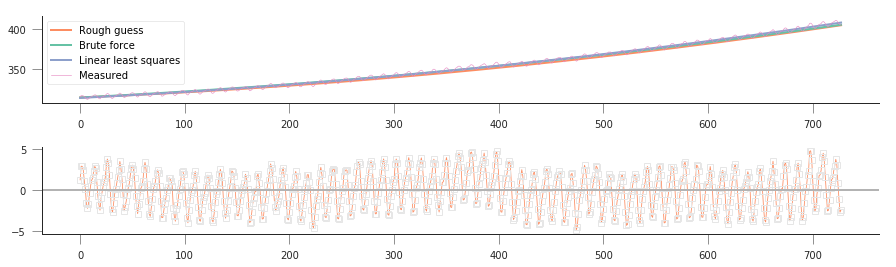

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 4))
x = np.arange(n_times)
a2 = 315.

axs[0].plot(x, quadratic_model(rough_guess, x), '-', label="Rough guess")
axs[0].plot(
    x, quadratic_model([yy_opt, xx_opt, a2], x), '-', label="Brute force")
axs[0].plot(x, quadratic_model(xopt, x), '-', label="Linear least squares")
axs[0].plot(x, co2.interpolated, '-', lw=0.6, label="Measured")
axs[0].legend(loc="best")

axs[1].plot(
    x,
    co2.interpolated - quadratic_model(xopt, x),
    's-',
    lw=0.8,
    mfc="none",
    mec="0.9")
axs[1].axhline(0, color="0.7")

So we can see that the optimal value is quite similar to the other two solutions, but results in a better fit (3470 versus 4090). We can see that with this method we can solve for all three parameters, even though our first guess of 315 for $a_2$ was pretty close to the true solution. 

<div class="alert alert-danger">
Try to use the linear least squares method to fit the first order linear model that we fitted "by eye" at the start of the notebook.
</div>

## A model with seasonality

While the quadratic model appears to go through the centre of the Mauna Loa curve, it clearly misses an important feature: the seasonality of the $CO_2$ concentration. We can't really emulate that behaviour with a simple quadratic function, but need a different model, one that deals with the seasonality. We can think that the seasonality is an additive cosine term, so that our model for $CO_2$ concentration is now

$$
W_i = a_0\cdot t_i^2 + a_1\cdot t_i + a_2 + a_3\cdot \cos\left(2\pi\frac{t_i}{T}  \right),
$$
where $T$ is the period of the seasonality, in this case, annual so $T=12$.

Although the model looks quite ugly, we see that we can write it like a sum (or a *linear combination*) of some functions ($t^2,\,t,$, the cosine term) weighted by the model parameters $a_0, \cdots, a_3$. So this is a linear model like the ones we've seen before and with which you should be familiar.

In this case, the $\mathbf{A}$ matrix is now given by 

$$
\mathbf{A}=\begin{bmatrix}  
t_1^2 & t_1 & 1 & \cos \left( 2\pi\frac{t_1}{T}\right)\\
t_2^2 & t_2 & 1 & \cos \left( 2\pi\frac{t_2}{T}\right)\\
t_3^2 & t_3 & 1 & \cos \left( 2\pi\frac{t_3}{T}\right)\\
\vdots & \vdots & \vdots & \vdots \\
t_N^2 & t_N & 1 & \cos \left( 2\pi\frac{t_N}{T}\right)\\
\end{bmatrix}.
$$

We can still solve the problem by making use of `lstsq`. Let's see how that works!

In [17]:
def quadratic_with_season(p, t, period=12.):
    a0, a1, a2, a3 = p
    return a0 * t * t + a1 * t + a2 + a3 * np.cos(2 * np.pi * (t / period))


period = 12.
# We create the A matrix
x = np.arange(n_times)
A = np.array([x * x, x, np.ones_like(x),
              np.cos(2 * np.pi * (x / period))])
# Now put the observations into y
y = co2.interpolated

# Call lstsq
xopt, sum_of_residuals, r, evals = np.linalg.lstsq(A.T, y)
for par in range(4):
    print("a{}:         {:08.5e}".format(par, xopt[par]))
print(f"Sum of squares: {float(sum_of_residuals):g}")

a0:         8.80710e-05
a1:         6.52761e-02
a2:         3.14461e+02
a3:         2.28764e+00
Sum of squares: 1654.67


/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app


Let's do some plots of the function fitting and residuals, and compare to previous results...


<div class="alert alert-danger">
Doing these sort of plots should be second nature to you by now. So do them!
</div>


/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


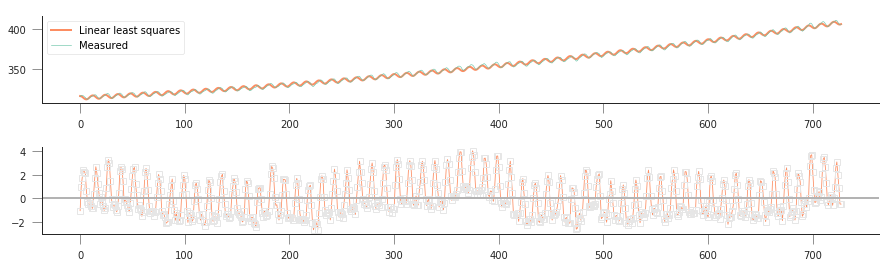

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 4))
x = np.arange(n_times)
a2 = 315.

axs[0].plot(x, quadratic_with_season(xopt, x), '-', label="Linear least squares")
axs[0].plot(x, co2.interpolated, '-', lw=0.6, label="Measured")
axs[0].legend(loc="best")

axs[1].plot(
    x,
    co2.interpolated - quadratic_with_season(xopt, x),
    's-',
    lw=0.8,
    mfc="none",
    mec="0.9")
axs[1].axhline(0, color="0.7")

So that's pretty good: by adding a simple cosine term, we can now start to model the annual seasonality in the measurements, and the sum of squared residuals is now further shrunk to around 1500. This is good, but in some ways unsurprising: you're now solving for 4 parameters, rather than 3 or 2 (for the simple linear case), so you have more degrees of freedom, and you expect to be able to fit your data better. 

## A phase shift

Looking at the residuals, we might decide that there's some mileage in shifting the cosine term a bit to get a better fit. We could do this by adding a phase shift so that the cosine terms would look like

$$
\cos\left[ \frac{2\pi}{T}(t+\phi)\right]
$$

However, it'd be hard to guess $\phi$ (we've effectively assumed it was 0 radians above!). So we'd need to use some non-linear solving approach. However, we might exploit the following trigonometrical identity:

$$
A\cos(\theta) + B\sin(\theta)=C\sin(\theta + \phi),
$$

<div class="alert alert-success">
Can you prove the above identity? 
</div>


This means that we can just add (drumroll...) yet another term to our model (a sine term), and the ratio of the cosine and sine terms will result in a phase shift. As we're adding another term, we expect a better result, but in this case, we hope that the aim of adding this extra term is to have **uncorrelated residuals around 0**.

<div class="alert alert-danger">
You should be able to do this yourself, including model fitting and plotting.
</div>


In [21]:
def quadratic_with_season_shift(p, t, period=12.):
    a0, a1, a2, a3, a4 = p
    return a0 * t * t + a1 * t + a2 + \
                a3 * np.cos(2 * np.pi * (t / period)) + \
                a4 * np.sin(2 * np.pi * (t / period)) 



period = 12.
# We create the A matrix
x = np.arange(n_times)
A = np.array([x * x, x, np.ones_like(x),
              np.cos(2 * np.pi * (x / period)),
              np.sin(2 * np.pi * (x / period))])
# Now put the observations into y
y = co2.interpolated

# Call lstsq
xopt, sum_of_residuals, r, evals = np.linalg.lstsq(A.T, y)
for par in range(5):
    print("a{}:         {:08.5e}".format(par, xopt[par]))
print(f"Sum of squares: {float(sum_of_residuals):g}")

a0:         8.76557e-05
a1:         6.55875e-02
a2:         3.14413e+02
a3:         2.28558e+00
a4:         1.66696e+00
Sum of squares: 645.521


/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


The squared sum of residuals is now around 645, again an improvement on the solution. We can see the fit and residuals I got (yours should be similar) here

![quadratic with seasonal shift](images/quadratic_season_shift.png)

We're now within the +/- 2 units band, which is a reasonable estimate.

## Prediction

A model isn't very good if you don't challenge it to predict phenomean outside the training range. We could just extend the $x-$ axis further left or right and see what the model predicts, but we'd be **extrapolating**. 

<div class="alert alert-success">
Given the simplicity of the model, and what you know about $CO_2$ dynamics over the past ~100 years, would you trust these extrapolations?
</div>

We can sort of mimic this behaviour by fitting the model only to a subset of years, and then test it for the rest of the available time series. For example, fit for the first 20 years, and then forecasat the remaining years. Or fit the last 20 years and forecast the previous years until the 1950s... If the model is successful in its predictions, then we can say that the model is probably OK, but if the quality of the predictions is poor, then we need to start thinking about **discarding** the model, and looking for alternatives!



<div class="alert alert-danger">
Fit the model to the first 30 years of data, and then use it to predict the <b>complete</b> time series. Your result should look something like below. Can you explain what's going on there?
</div>

![Extrapolation plot](images/extrapolation.png)

## Uncertainty

We have not said anything about how the model predictions are *uncertain*: we only used a limited dataset, with measurements errors associated to it. Even within the training period, the residuals are not 0, so we can expect that the model has some bits of reality missing from it (it *is* a model, after all!). Uncertainty would allow us to  quantify how good or bad the predictions from the model are, but so far, we have ignored it...

<div class="alert alert-success">
In the 30 year training experiment, can you sketch how you think uncertainty should look like?
</div>


In [22]:
def quadratic_with_season_shift(p, t, period=12.):
    a0, a1, a2, a3, a4 = p
    return a0 * t * t + a1 * t + a2 + \
                a3 * np.cos(2 * np.pi * (t / period)) + \
                a4 * np.sin(2 * np.pi * (t / period)) 



period = 12.
# We create the A matrix
x = np.arange(n_times)[:12*30]
A = np.array([x * x, x, np.ones_like(x),
              np.cos(2 * np.pi * (x / period)),
              np.sin(2 * np.pi * (x / period))])
# Now put the observations into y
y = co2.interpolated[:12*30]

# Call lstsq
xopt, sum_of_residuals, r, evals = np.linalg.lstsq(A.T, y)
for par in range(5):
    print("a{}:         {:08.5e}".format(par, xopt[par]))
print(f"Sum of squares: {float(sum_of_residuals):g}")

a0:         1.37489e-04
a1:         4.93777e-02
a2:         3.15199e+02
a3:         2.10176e+00
a4:         1.70324e+00
Sum of squares: 166.009


/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
